# Table of Contents

1. [Import Libraries and Dataset](#import)
2. [Exploratory Data Analysis](#eda)
3. [Preprocessing](#preprocessing)
4. [Baseline Model](#base)
5. [Feature Engineering](#fe)
6. [Model Building](#finalmodels)
7. [Parameter Optimization](#opt)

# Import Libraries and Dataset <a id = 'import'></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
%matplotlib inline
from pathlib import Path
from scipy import stats

no display found. Using non-interactive Agg backend


In [2]:
# read data file
df= pd.read_csv('marketing_campaign.csv', delimiter = ';')
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,2013-09-09,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,2012-11-13,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,2013-05-08,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,...,20,1,0,0,0,0,0,3,11,0


In [3]:
# Get total number of rows and columns
df.shape

(2240, 29)

### Drop 'ID' column <a id = 'id'></a>

The ID column will not give us any useful information so we will drop it. 

In [4]:
# drop ID coloumn
df = df.drop(['ID'], axis = 1)

# Exploratory Data Analysis <a id = 'eda'></a>

Next, we will do an exploratory analysis on the dataset, to summarize it and also get an understanding of what we are working with.

### 1 a. Target Variable 

As per the dataset the column Response (target) in itself is one of the campaigns (last campaign). So, in total there are 6 campaigns.

Let's create a target variable called 'Customer_Response' where the value will be 1 if the customer responds to any of the 6 campaigns and 0 if the customer has not responded to any campaign. 

In [5]:
df['Customer_Response'] = np.where(df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1) >= 1, 1, 0)

In [6]:
# Renaming the 6th campaign name to intuitive column name 
df.rename(columns={'Response': 'AcceptedCmp6'}, inplace=True)

In [7]:
df['Customer_Response'].value_counts()

0    1631
1     609
Name: Customer_Response, dtype: int64

1631 is the number of instances for 0 which tells that there are 1631 customers who have not responded to the any of the campaign.

609 is the number of instances for 1 which tells that there are 609 customers who have responded to atleast one of the campaign.

We can also see that creating the 'Customer_Reponse' variable reduced the number of '0's and provides a holoistic view if the customers ever accepted the offers through the campaigns

As new target variable i.e 'Customer_response' is created from the 6 campaigns , there is no more use of the 6 campaign columns, so we can drop it.

Also dropping column 'Z_CostContact' & 'Z_Revenue' as they are constant variables.

In [8]:
df = df.drop(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp6', 'Z_CostContact', 'Z_Revenue'], axis = 1)

### 1 b. Missing Values & Duplicates 

Checking the type of data to understand what all columns it contains and of what types and whether they contain any value or not.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

So we see that we have 3 categorical variables and 26 numerical variables. We can also see that there are missing values in the column 'Income'. We will do missing value treatment later. 

In [10]:
# Recalculating the missing values in the dataset
df.isnull().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Customer_Response       0
dtype: int64

Only 'Income' valriable has missing values. There are 24 missing values for the 'Income' variable. 

Let's understand more about column 'Income'

Based on above table, there are no anomalies found in terms of '0's in the variables

In [11]:
 df["Income"].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

Handling missing values can be done in few ways- 

We can delete the entire column containing null-values

delete the rows containing null-values or can impute the mean value

So, let's treat the missing values in 'Income' column by Imputation method.

Imputation fills in the missing value with some number. The imputed value won't be exactly right in most cases, but it usually gives more accurate models than dropping the column entirely.

In [12]:
missing_col = ['Income']
#Technique : Using mean to impute the missing values
for i in missing_col:
    df.loc[df.loc[:,i].isnull(),i]=df.loc[:,i].mean()

In [13]:
print("count of NULL values after imputation\n")
df.isnull().sum()

count of NULL values after imputation



Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Complain               0
Customer_Response      0
dtype: int64

Now there are no null values after imputation

In [14]:
# Calculating number of Zeroes in each of the columns to find anomalies if any (such as high number of zeroes in Year_Birth)
df.isin([0]).sum()

Year_Birth                0
Education                 0
Marital_Status            0
Income                    0
Kidhome                1293
Teenhome               1158
Dt_Customer               0
Recency                  28
MntWines                 13
MntFruits               400
MntMeatProducts           1
MntFishProducts         384
MntSweetProducts        419
MntGoldProds             61
NumDealsPurchases        46
NumWebPurchases          49
NumCatalogPurchases     586
NumStorePurchases        15
NumWebVisitsMonth        11
Complain               2219
Customer_Response      1631
dtype: int64

Based on above table, there are no anomalies found in terms of '0's in the variables

### Checking for duplicates

Let's check for duplicate rows and drop them if necessary. Then we'll do a recount of duplicates to double check that they were dropped.

In [15]:
# duplicate count
df.duplicated().sum()

189

In [16]:
# drop duplicates and reset index
df = df.drop_duplicates().reset_index(drop = True)

In [17]:
# The duplicated values are indicated as True values in the resulting Series
df.duplicated().sum()

0

After performing the action to remove duplicates the total number of rows are still 2240 which tells that there are no duplicate values in the dataset.

### 1 c. Variable Relationships 

In [18]:
df.shape

(2051, 21)

In [19]:
# Statistical summary of data frame
df.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Customer_Response
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1968.798147,52337.652381,0.445636,0.508532,48.972696,302.902974,26.227694,167.313506,37.300341,27.128230,43.893223,2.333496,4.098489,2.657728,5.767918,5.319844,0.009751,0.274013
std,11.970297,25382.967842,0.537695,0.546653,29.005100,335.657543,39.743769,227.513616,54.591382,41.621742,52.186942,1.934272,2.799138,2.936044,3.238302,2.440130,0.098290,0.446124
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,1945.000000,7500.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
10%,1952.000000,24336.000000,0.000000,0.000000,9.000000,6.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000
20%,1957.000000,32313.000000,0.000000,0.000000,19.000000,16.000000,1.000000,12.000000,2.000000,1.000000,6.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000
30%,1962.000000,38547.000000,0.000000,0.000000,29.000000,34.000000,2.000000,20.000000,3.000000,2.000000,11.000000,1.000000,2.000000,1.000000,3.000000,4.000000,0.000000,0.000000
40%,1966.000000,45072.000000,0.000000,0.000000,39.000000,84.000000,4.000000,35.000000,7.000000,5.000000,16.000000,1.000000,3.000000,1.000000,4.000000,5.000000,0.000000,0.000000
50%,1970.000000,52034.000000,0.000000,0.000000,49.000000,173.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000


To understand the relationship between dependent variable and independent variables, creating plot and heatmap

In [20]:
predictors = [ 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain']

outcome = 'Customer_Response'


/Users/akhilapamukuntla/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Customer_Response', ylabel='Density'>

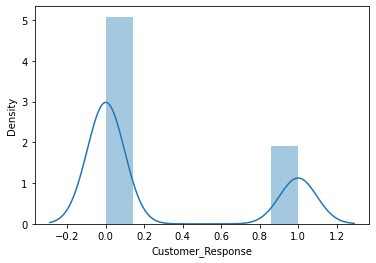

In [21]:
sns.distplot(df['Customer_Response'])

Above graph shows the ratio between the customers who responded to any of the campaigns and those who never responded to any campaign

In [22]:
df['Customer_Response'].sum()

562

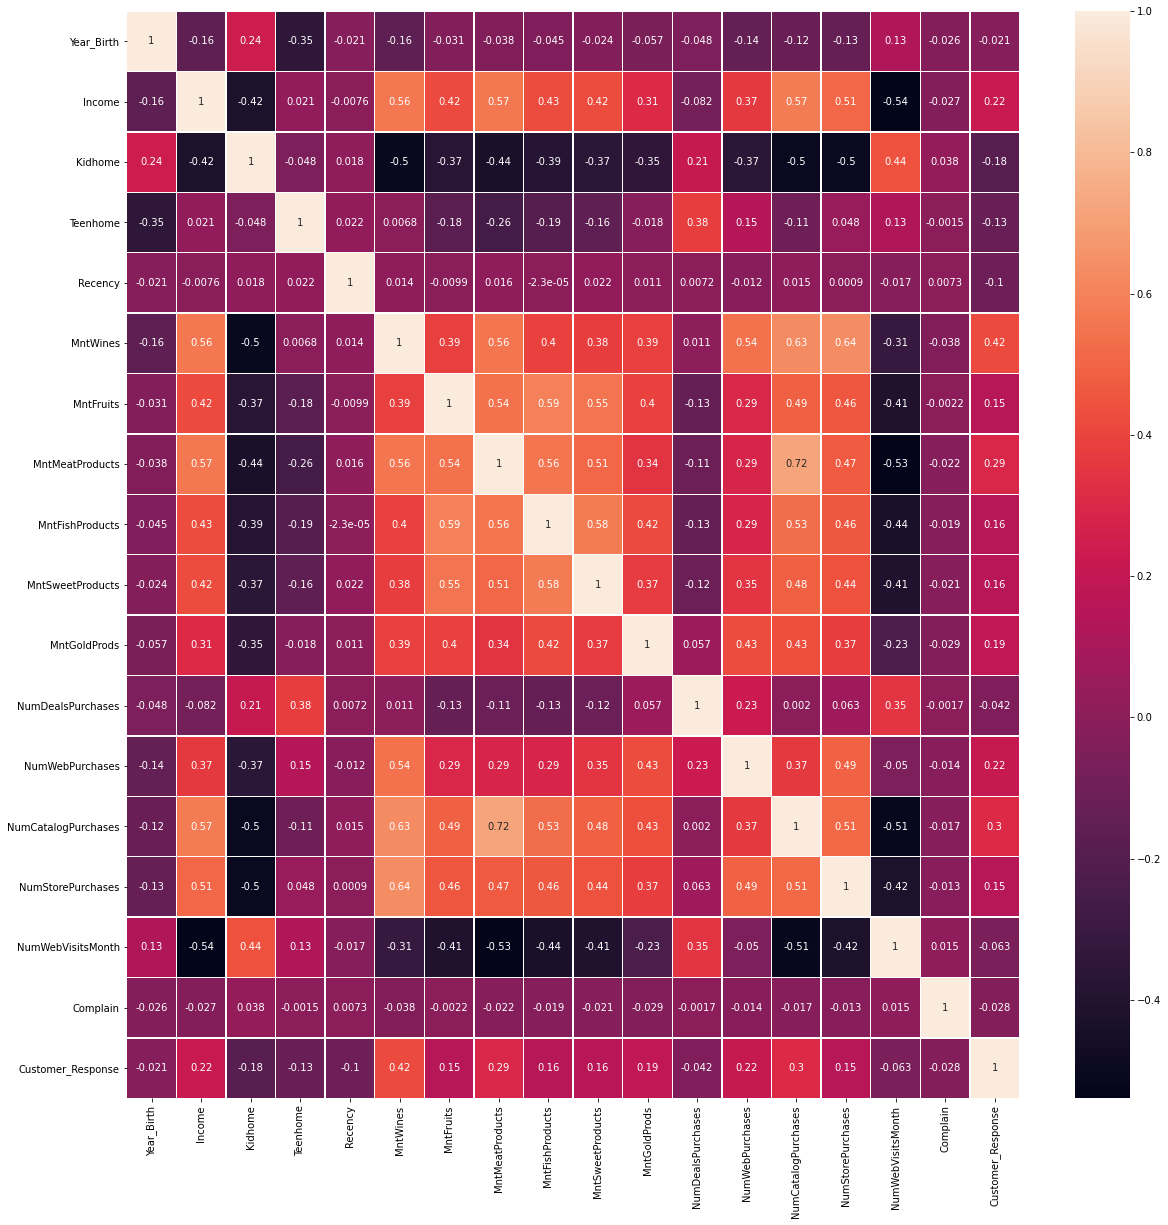

In [23]:
df_small = df.iloc[:,:29]
correlation_mat = df_small.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlation_mat, annot = True, linewidths=.5)
plt.show()

Each square of the heatmap shows correlation between the variables on each axis. Values closer to zero means there is no linear trend between the two variables. The close to 1 correlation is positively correlated. Taking positive 0.4 as the benchmark, we can check which variables have more postive corelarion with other variables.

Identifying the outliers with interquartile range

In [24]:
#Sorting the dataset
# 50th percentile is median
sorted(df)
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
print(IQR)

Year_Birth                18.0
Income                 32516.5
Kidhome                    1.0
Teenhome                   1.0
Recency                   50.0
MntWines                 479.5
MntFruits                 31.5
MntMeatProducts          213.0
MntFishProducts           47.0
MntSweetProducts          32.5
MntGoldProds              47.0
NumDealsPurchases          2.0
NumWebPurchases            4.0
NumCatalogPurchases        4.0
NumStorePurchases          5.0
NumWebVisitsMonth          4.0
Complain                   0.0
Customer_Response          1.0
dtype: float64


In [25]:
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

<ipython-input-25-40a85132028f>:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
<ipython-input-25-40a85132028f>:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()


Complain                20
Customer_Response        0
Dt_Customer              0
Education                0
Income                   8
Kidhome                  0
Marital_Status           0
MntFishProducts        202
MntFruits              211
MntGoldProds           187
MntMeatProducts        174
MntSweetProducts       223
MntWines                34
NumCatalogPurchases     22
NumDealsPurchases       77
NumStorePurchases        0
NumWebPurchases          4
NumWebVisitsMonth        8
Recency                  0
Teenhome                 0
Year_Birth               3
dtype: int64

Here Complain variable do not require an outlier treatment as it has binary values(1, 0)

Outlier treatment has to be done. There are different outlier treatment like by calculating mean and median, but the one of the most commonly used approach is calculating percentile  value and replacing the outliers with that percentile value. 

After doing the outlier treatment then we again find the relationship between variables.

Understanding the outliers with visualization and treating it 

In [26]:
#Shows the skewness value of Income and also summary statistics
print(df['Income'].skew())
df['Income'].describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

7.120444939794689


count      2051.000000
mean      52337.652381
std       25382.967842
min        1730.000000
1%         7500.000000
10%       24336.000000
20%       32313.000000
30%       38547.000000
40%       45072.000000
50%       52034.000000
60%       58025.000000
70%       65031.000000
80%       71670.000000
90%       79761.000000
99%       94557.000000
max      666666.000000
Name: Income, dtype: float64

The skewness value of 6.8 shows that the variable 'Income' has right-skewes distribution, imdicating presence of extreme values. Based on research, skewness value greater than 3.5 shows skewness.
https://stats.stackexchange.com/questions/436274/performing-t-test-on-highly-skewed-financial-data-outlier-treatment#:~:text=After%20treating%20for%20outliers%2C%20most,and%20%2B1.5%20max%20is%203.5.

### Outlier Treatment
### Quantile-based Flooring and Capping

In [27]:
print(df['Income'].quantile(0.5))
print(df['Income'].quantile(0.99))

52034.0
94557.0


Now we will remove the outliers of 'Income' and calculate the skewness value again

1.1653097906825942


<AxesSubplot:>

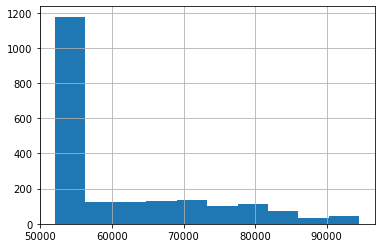

In [28]:
df["Income"] = np.where(df["Income"] <df['Income'].quantile(0.5), df['Income'].quantile(0.5),df['Income'])
df["Income"] = np.where(df["Income"] >df['Income'].quantile(0.99), df['Income'].quantile(0.99),df['Income'])
print(df['Income'].skew())
df.Income.hist()

In [29]:
#Outlier treatment for "MntMeatProducts"
print(df['MntMeatProducts'].quantile(0.1))
print(df['MntMeatProducts'].quantile(0.99))

7.0
923.0


In [30]:
df["MntMeatProducts"] = np.where(df["MntMeatProducts"] <df['MntMeatProducts'].quantile(0.1), df['MntMeatProducts'].quantile(0.1),df['MntMeatProducts'])
df["MntMeatProducts"] = np.where(df["MntMeatProducts"] >df['MntMeatProducts'].quantile(0.99), df['MntMeatProducts'].quantile(0.99),df['MntMeatProducts'])

1.7238773596047992


<AxesSubplot:>

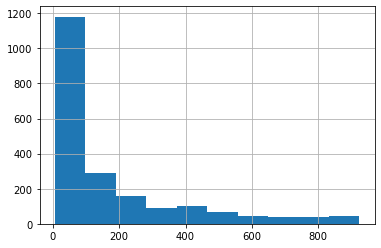

In [31]:
#After treatment SKewness and distribution of data points through histogram.
print(df['MntMeatProducts'].skew())
df.MntMeatProducts.hist()

In [32]:
#Outlier treatment for "NumWebPurchases"
print(df['NumWebPurchases'].quantile(0.01))
print(df['NumWebPurchases'].quantile(0.99))

0.0
11.0


In [33]:
df["NumWebPurchases"] = np.where(df["NumWebPurchases"] <df['NumWebPurchases'].quantile(0.01), df['NumWebPurchases'].quantile(0.01),df['NumWebPurchases'])
df["NumWebPurchases"] = np.where(df["NumWebPurchases"] >df['NumWebPurchases'].quantile(0.99), df['NumWebPurchases'].quantile(0.99),df['NumWebPurchases'])

0.70144368248077


<AxesSubplot:>

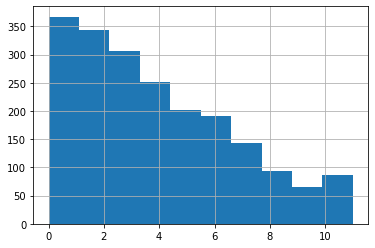

In [34]:
#After treatment SKewness and distribution of data points through histogram.
print(df['NumWebPurchases'].skew())
df.NumWebPurchases.hist()

In [35]:
print(df['NumCatalogPurchases'].quantile(0.01))
print(df['NumCatalogPurchases'].quantile(0.99))

0.0
11.0


In [36]:
df["NumCatalogPurchases"] = np.where(df["NumCatalogPurchases"] <df['NumCatalogPurchases'].quantile(0.01), df['NumCatalogPurchases'].quantile(0.01),df['NumCatalogPurchases'])
df["NumCatalogPurchases"] = np.where(df["NumCatalogPurchases"] >df['NumCatalogPurchases'].quantile(0.99), df['NumCatalogPurchases'].quantile(0.99),df['NumCatalogPurchases'])

1.1344367713369197


<AxesSubplot:>

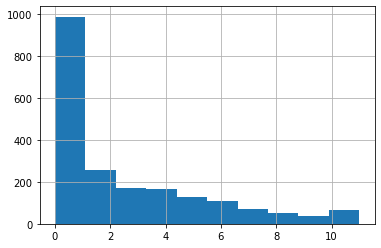

In [37]:
print(df['NumCatalogPurchases'].skew())
df.NumCatalogPurchases.hist()

In [38]:
print(df['NumWebVisitsMonth'].quantile(0.01))
print(df['NumWebVisitsMonth'].quantile(0.99))

1.0
9.0


In [39]:
df["NumWebVisitsMonth"] = np.where(df["NumWebVisitsMonth"] <df['NumWebVisitsMonth'].quantile(0.01),df['NumWebVisitsMonth'].quantile(0.01),df['NumWebVisitsMonth'])
df["NumWebVisitsMonth"] = np.where(df["NumWebVisitsMonth"] >df['NumWebVisitsMonth'].quantile(0.99), df['NumWebVisitsMonth'].quantile(0.99),df['NumWebVisitsMonth'])

-0.3320145683081151


<AxesSubplot:>

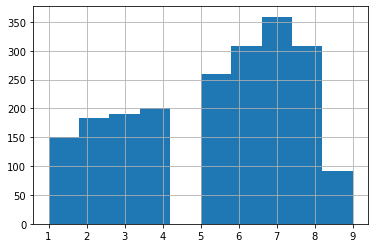

In [40]:
print(df['NumWebVisitsMonth'].skew())
df.NumWebVisitsMonth.hist()

Same # of rows before and after Outlier treatment

In [41]:
df.shape

(2051, 21)

To understand the types of marital status in the dataset, listed unique values in the Marital_Status column.


In [42]:
df.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

From Business perspective, accepted Marital Status coule be single, married, together(not married), divorced, and widow. Apart from these marital status, the rest that are 'Alone', 'YOLO', 'Absurd' can be considered as 'Single'. 

So replacing the data cells which have 'Alone', 'YOLO', 'Absurd' with 'Single'.

In [43]:
df['Marital_Status'] = df['Marital_Status'].replace(['Absurd','YOLO','Alone'],['Single','Single','Single'])

In [44]:
df.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow'], dtype=object)

To understand the types of Education that respondents have in the dataset, listed unique values in the 'Eduction' column

In [45]:
df.Education.unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

### Correlation Matrix after Outlier Treatment

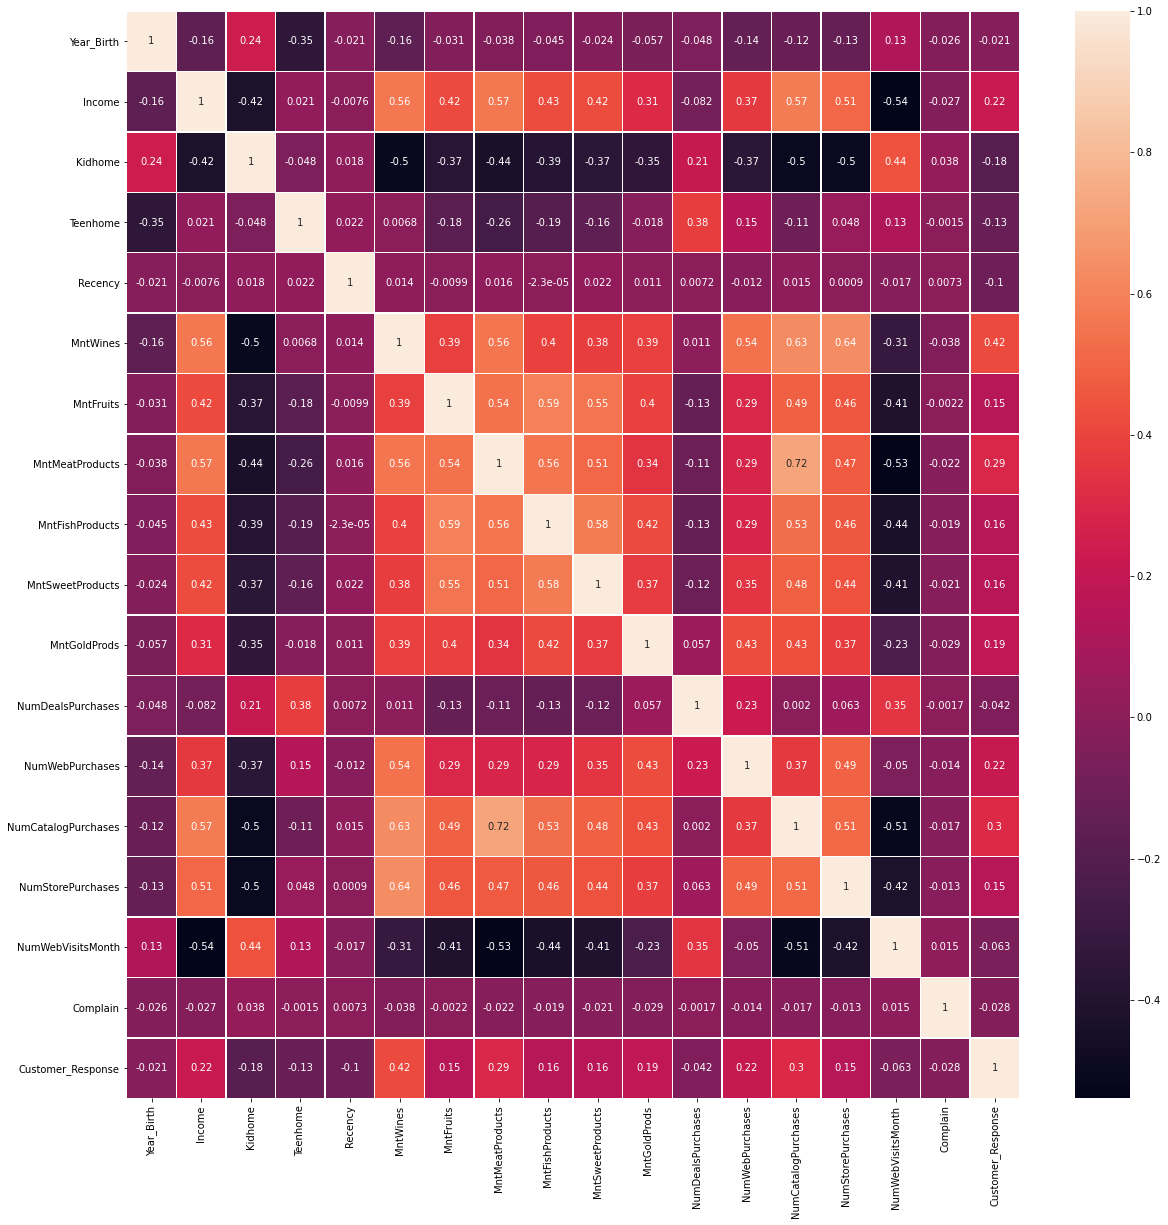

In [46]:
df_after = df.iloc[:,:29]
correlation_mat = df_small.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlation_mat, annot = True, linewidths=.5)
plt.show()

In [47]:
# Education has 2n Cycle and Master which means the same so we will change that

In [48]:
df['Education'].value_counts().index.sort_values(ascending=True)

Index(['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD'], dtype='object')

In [49]:
df['Education'] = df["Education"].replace('2n Cycle', "Master")

# Baseline Model<a id = 'base'></a>

Here we'll run a baseline model without feature engineering to get an idea of the predictive power of some models. We decided to use a variety of models to compare and contrast. The models are Logistic Regression, Support Vector Machines, Stoachasic Gradient Descent, K-nearest neighbor Classifer, Decission Trees, Multi-Layer Perception Classifier, and Naive Bayes. We will run them all at the same time and compare the performence metrics of each.

In [50]:
# specify attributes and target column
predictors = ['Year_Birth','Education','Income','Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts',
              'MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases',
              'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain']
outcome = 'Customer_Response'

In [51]:
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]

In [52]:
# Import all models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# List all the models to be fitted
models_store = [LogisticRegression(random_state=0, max_iter=1000),
                SVC(gamma='auto'),
                SGDClassifier(max_iter=1000, tol=1e-3),
                KNeighborsClassifier(n_neighbors=3),
                DecisionTreeClassifier(random_state=0),
                MLPClassifier(random_state=1, max_iter=1000),
                GaussianNB()]

# String values of the models
models_names = ['LogisticRegression', 
                'SVC', 
                'SGD', 
                'KNNClassifer', 
                'DecisionTree', 
                'MLPClassifer',
                'GaussianNB']

In [53]:
from sklearn.model_selection import cross_validate

#empty array to hold peformance of all model
acc_storage = []
prec_storage = []
recall_storage = []
f1_storage = []

#loop through all models and run each one according to the pipeline steps
for model in models_store:
    
    #performance metrics
    # get mean of each performance metric during cross validation
    scores = cross_validate(model, X, y, cv = 4, scoring = ('accuracy', 'precision', 'recall', 'f1'))
    acc_avg_score = scores['test_accuracy'].mean()
    prec_avg_score = scores['test_precision'].mean()
    recall_avg_score = scores['test_recall'].mean()
    f1_avg_score = scores['test_f1'].mean()

    # get the ranges
    acc_performance = str(round(acc_avg_score,5)) + ' +/- ' + str(round((scores['test_accuracy'].max()-acc_avg_score),5))
    prec_performance = str(round(prec_avg_score,5)) + ' +/- ' + str(round((scores['test_precision'].max()-prec_avg_score),5))
    recall_performance = str(round(recall_avg_score,5)) + ' +/- ' + str(round((scores['test_recall'].max()-recall_avg_score),5))
    f1_performance = str(round(f1_avg_score,5)) + ' +/- ' + str(round((scores['test_f1'].max()-f1_avg_score),5))

    acc_storage.append(acc_performance)
    prec_storage.append(prec_performance)
    recall_storage.append(recall_performance)
    f1_storage.append(f1_performance)

#display performance 
df_metric = pd.DataFrame(data = {'Models' : models_names, 
                                 'accuracy' : acc_storage,
                                 'precision' : prec_storage,
                                 'recall' : recall_storage,
                                 'f1': f1_storage})

df_metric.sort_values(by = 'accuracy', ascending = False)

,Models,accuracy,precision,recall,f1
0,LogisticRegression,0.78206 +/- 0.00895,0.67795 +/- 0.06118,0.40203 +/- 0.05897,0.50193 +/- 0.03526
2,SGD,0.75623 +/- 0.0274,0.66733 +/- 0.15876,0.36662 +/- 0.19367,0.43116 +/- 0.08832
3,KNNClassifer,0.73379 +/- 0.01475,0.52045 +/- 0.03745,0.41097 +/- 0.02875,0.45824 +/- 0.02238
1,SVC,0.72257 +/- 0.00452,0.3625 +/- 0.6375,0.00533 +/- 0.00181,0.01042 +/- 0.00367
6,GaussianNB,0.71331 +/- 0.01574,0.48091 +/- 0.02259,0.54977 +/- 0.03179,0.51234 +/- 0.00339
4,DecisionTree,0.71039 +/- 0.01476,0.47214 +/- 0.02786,0.49107 +/- 0.04794,0.48127 +/- 0.0375
5,MLPClassifer,0.64023 +/- 0.12975,0.53031 +/- 0.12683,0.46017 +/- 0.51855,0.39935 +/- 0.03875


So far, it looks like logistic regression is the best. 

# Feature engineering<a id = 'fe'></a>

This will help improve the performance of our models. It will increase the predictive power of our algorithm

### Column Adjustments for ML

Reset the indexing of the dataset to avoid any issues when using loops.

In [54]:
df = df.reset_index(drop = True)

Adding age of the customer to better undnerstand the demographics, dropping the Year_Birth col since we now have age

In [55]:
df['Age'] = 2021 - df['Year_Birth']

df.drop('Year_Birth', axis=1, inplace=True)

Dt_Customer represents the date since the customer has been with the company

In [56]:
import datetime as dt

# Change Dt_Customer to Num_days_cust
# Get todays date
df['DateTimeToday'] = dt.datetime.today()

# convert date string to DateTime format
df['DateTimeConvert'] = pd.to_datetime(df['Dt_Customer'],format='%Y-%m-%d')

# Get difference in days
df['DateTimeDifference'] = df['DateTimeToday'] - df['DateTimeConvert']

# Initialize difference in int column
df['DaysCustomer'] = 0

# Convert days difference to int
for x in range(len(df)):
    df.at[x, 'DaysCustomer'] = df['DateTimeDifference'][x].days

Customer Spending - Sum of all products

We should remove all the other cols, since the aggregate spending should be enough. Unless we want to analyse spending on each product 

In [57]:
df['Spending']=df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

Added a Martial Status to indicate if the person is Alone, Couple or Married

In [58]:
df['Marital_Status']=df['Marital_Status'].replace({'Divorced':'Alone','Single':'Alone','Married':'In couple','Together':'In couple','Absurd':'Alone','Widow':'Alone'})

### Dummy Code

ML models do not handle categorical data in text form well. We need to transform the categorical columns into multiple true/false columns for the domains in each column.

In [59]:
# dummy code
df_dummied = pd.get_dummies(df, columns=['Education', 'Marital_Status'], prefix_sep='_', drop_first=True)
df_dummied.head(5)

,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Age,DateTimeToday,DateTimeConvert,DateTimeDifference,DaysCustomer,Spending,Education_Graduation,Education_Master,Education_PhD,Marital_Status_In couple
0,58138.0,0,0,2012-09-04,58,635,88,546.0,172,88,...,64,2021-05-02 15:19:24.261316,2012-09-04,3162 days 15:19:24.261316,3162,1617.0,1,0,0,0
1,52034.0,1,1,2014-03-08,38,11,1,7.0,2,1,...,67,2021-05-02 15:19:24.261316,2014-03-08,2612 days 15:19:24.261316,2612,28.0,1,0,0,0
2,71613.0,0,0,2013-08-21,26,426,49,127.0,111,21,...,56,2021-05-02 15:19:24.261316,2013-08-21,2811 days 15:19:24.261316,2811,776.0,1,0,0,1
3,52034.0,1,0,2014-02-10,26,11,4,20.0,10,3,...,37,2021-05-02 15:19:24.261316,2014-02-10,2638 days 15:19:24.261316,2638,53.0,1,0,0,1
4,58293.0,1,0,2014-01-19,94,173,43,118.0,46,27,...,40,2021-05-02 15:19:24.261316,2014-01-19,2660 days 15:19:24.261316,2660,422.0,0,0,1,1


### Standard Scale

Sometimes large values or small values in numerical data can have exponential effects on the outcome. We can normalize the numerical columns to overcome them.

In [60]:
from sklearn import preprocessing

# Specify columns, exclude categorical and target variable
df_numerical = df_dummied[['Income',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain',
       'Age', 'DaysCustomer', 'Spending']]

# Column names
names = df_numerical.columns

# Initialize scaler
scaler = preprocessing.StandardScaler()

# Fit data
scaled_num_df = scaler.fit_transform(df_numerical)
scaled_num_df = pd.DataFrame(scaled_num_df, columns=names)

In [61]:
# add back in categorical and target variables

df_add = df_dummied[['Kidhome', 'Teenhome', 'Customer_Response',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_In couple']]

df_scaled = pd.concat([scaled_num_df, df_add], axis=1)

### Add Cluster Column

We want to try to incorporate unsupervised machine learning into our supervised machine learning problem. We can use clustering to create a new column and predicts the cluster. This will be additional information in our end supervised machine learning models. 

In [62]:
# add clustering column
# remove target label
df_for_cluster = df_scaled[['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Age',
       'DaysCustomer', 'Spending', 'Kidhome', 'Teenhome',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_In couple']]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 89, cost: 31070.0
Run 1, iteration: 2/100, moves: 5, cost: 31070.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 235, cost: 30445.0
Run 1, iteration: 2/100, moves: 10, cost: 30445.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 339, cost: 29729.0
Run 1, iteration: 2/100, moves: 17, cost: 29729.0


/Users/akhilapamukuntla/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/akhilapamukuntla/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


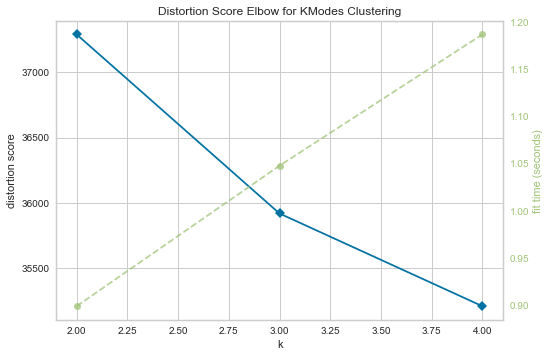

<AxesSubplot:title={'center':'Distortion Score Elbow for KModes Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
# Elbow Method for K modes to select optimal number of clusters
from yellowbrick.cluster import KElbowVisualizer
from kmodes.kmodes import KModes

model = KModes( init = 'Cao', n_init = 1, verbose=1)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,5), timings= True)
visualizer.fit(df_for_cluster)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [64]:
# Take a look at the clusters
# K-Modes with optimal number of clusters
km_cao = KModes(n_clusters=3, init = 'Cao', n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(df_scaled) # predict cluster

clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = df_scaled.columns
pd.options.display.max_columns = None

clusterCentroidsDf

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 182, cost: 31103.0
Run 1, iteration: 2/100, moves: 87, cost: 31074.0
Run 1, iteration: 3/100, moves: 7, cost: 31074.0


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Age,DaysCustomer,Spending,Kidhome,Teenhome,Customer_Response,Education_Graduation,Education_Master,Education_PhD,Marital_Status_In couple
0,-0.736286,0.242337,-0.887737,-0.660081,-0.729027,-0.683431,-0.651939,-0.822115,-0.689573,-0.781083,-0.951271,-0.854952,0.310237,-0.099234,-0.601790,-1.507249,-0.974584,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-0.736286,-1.309492,-0.893697,-0.584579,-0.729027,-0.683431,-0.651939,-0.611283,-0.172456,-0.781083,-0.589227,-0.546073,0.745460,-0.099234,-0.518230,-0.536404,-0.909398,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.736286,0.897554,-0.896677,-0.660081,-0.729027,-0.646786,-0.627907,-0.707116,-0.689573,-0.403786,-0.589227,-1.163831,0.745460,-0.099234,-0.434669,-1.536969,-0.961212,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [65]:
# Combine df and predicted cluter to one df
pred_df = df_scaled.reset_index()
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([pred_df, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

### Adjust Unbalanced Target Variable Values

As we seen in the exploratory data analysis, our target variable is highly skewed and contains mostly 0 values. This will not be enough information to predict the 1 values. We can upscale the 1 values to match the 0 values. Using Synethic Memory Oversampling Technique, we can create more 1 values. This technique does not simply duplicate more 1 values but synethizes them or creates 1 values that are similar to existing 1 values. 

In [70]:
combinedDf.columns

Index(['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Age',
       'DaysCustomer', 'Spending', 'Kidhome', 'Teenhome', 'Customer_Response',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_In couple', 'cluster_predicted'],
      dtype='object')

In [71]:
# adjust unbalanced dataset using SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE()

X_b4_sampling = combinedDf[['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Age',
       'DaysCustomer', 'Spending', 'Kidhome', 'Teenhome',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_In couple', 'cluster_predicted']]
y_b4_sampling = combinedDf['Customer_Response']

X_upsampled, y_upsampled = smt.fit_resample(X_b4_sampling, y_b4_sampling)

### Feature Importance

A feature importance ranking method we can use is Recursive Feature Elimination where the model is initially run with all the variables. Then an importance coefficient is obtained for each variable. Then the least important features are removed from the model. We can specify how many features we want to keep. Since Logistic Regression was our top performing model, we will use that as the base of RFE.


In [72]:
from sklearn.feature_selection import RFE

# the model
model = LogisticRegression(max_iter=1000)

#run RFE
rfe = RFE(model, 20)
rfe = rfe.fit(X_upsampled, y_upsampled)

#display the ranking of each variable
series1 = pd.Series(X_upsampled.columns.values)
series2 = pd.Series(rfe.ranking_)

rank = pd.DataFrame(data={'Variables': series1, 'Ranking' : series2})
rank.sort_values(by='Ranking')


/Users/akhilapamukuntla/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


,Variables,Ranking
0,Income,1
21,Education_PhD,1
20,Education_Master,1
19,Education_Graduation,1
18,Teenhome,1
17,Kidhome,1
16,Spending,1
15,DaysCustomer,1
14,Age,1
13,Complain,1


If we specify that we want to the 20 most important variables, we can see that the following columns are of least importance: NumDealsPurchases, NumWebPurchases, MntSweetProducts, and cluster_predicted.

# Model Building<a id = 'finalmodels'></a>

Here we will run the model again with adjustments made through feature engineering. 

In [73]:
# shuffle data before model

# put dataframe back together
combinedDf3 = pd.concat([X_upsampled, y_upsampled], axis = 1).reset_index()
combinedDf3 = combinedDf3.drop(['index'], axis = 1)

# shuffle data 
df_shuffled = combinedDf3.sample(frac = 1).reset_index()
df_shuffled = df_shuffled.drop(['index'], axis = 1)

# redefine train and target
X2 = df_shuffled[['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Age',
       'DaysCustomer', 'Spending', 'Kidhome', 'Teenhome',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_In couple', 'cluster_predicted']]

y2 = df_shuffled['Customer_Response']

In [74]:
# Rerun model with new features and changes

X3 = X2
y3 = y2

# List all the models to be fitted
models_store = [LogisticRegression(random_state=0, max_iter=1000),
                SVC(gamma='auto'),
                SGDClassifier(max_iter=1000, tol=1e-3),
                KNeighborsClassifier(n_neighbors=3),
                DecisionTreeClassifier(random_state=0),
                MLPClassifier(random_state=1, max_iter=1000),
                GaussianNB()]

# String values of the models
models_names = ['LogisticRegression', 
                'SVC', 
                'SGD', 
                'KNNClassifer', 
                'DecisionTree', 
                'MLPClassifer',
                'GaussianNB']

#empty array to hold peformance of all model
acc_storage2 = []
prec_storage2 = []
recall_storage2 = []
f1_storage2 = []

#loop through all models and run each one according to the pipeline steps
for model in models_store:
    
    #performance metrics
    scores = cross_validate(model, X3, y3, cv = 4, scoring = ('accuracy', 'precision', 'recall', 'f1'))
    acc_avg_score = scores['test_accuracy'].mean()
    prec_avg_score = scores['test_precision'].mean()
    recall_avg_score = scores['test_recall'].mean()
    f1_avg_score = scores['test_f1'].mean()

    
    acc_performance = str(round(acc_avg_score,5)) + ' +/- ' + str(round((scores['test_accuracy'].max()-acc_avg_score),5))
    prec_performance = str(round(prec_avg_score,5)) + ' +/- ' + str(round((scores['test_precision'].max()-prec_avg_score),5))
    recall_performance = str(round(recall_avg_score,5)) + ' +/- ' + str(round((scores['test_recall'].max()-recall_avg_score),5))
    f1_performance = str(round(f1_avg_score,5)) + ' +/- ' + str(round((scores['test_f1'].max()-f1_avg_score),5))

    acc_storage2.append(acc_performance)
    prec_storage2.append(prec_performance)
    recall_storage2.append(recall_performance)
    f1_storage2.append(f1_performance)

#display performance 
df_metric = pd.DataFrame(data = {'Models' : models_names, 
                                 'accuracy' : acc_storage2,
                                 'precision' : prec_storage2,
                                 'recall' : recall_storage2,
                                 'f1': f1_storage2})

df_metric.sort_values(by = 'accuracy', ascending = False)

,Models,accuracy,precision,recall,f1
5,MLPClassifer,0.84284 +/- 0.01353,0.82943 +/- 0.01166,0.86365 +/- 0.02107,0.84593 +/- 0.01457
3,KNNClassifer,0.81397 +/- 0.00751,0.75887 +/- 0.01088,0.92075 +/- 0.00687,0.83195 +/- 0.00486
1,SVC,0.80053 +/- 0.01826,0.80756 +/- 0.01062,0.7891 +/- 0.03128,0.79811 +/- 0.02117
4,DecisionTree,0.78508 +/- 0.01626,0.77353 +/- 0.02021,0.80658 +/- 0.01869,0.78959 +/- 0.01464
0,LogisticRegression,0.7646 +/- 0.01527,0.78682 +/- 0.00628,0.72597 +/- 0.03543,0.75481 +/- 0.02114
2,SGD,0.74143 +/- 0.02904,0.75514 +/- 0.01783,0.71454 +/- 0.05222,0.73401 +/- 0.03584
6,GaussianNB,0.66857 +/- 0.01466,0.68577 +/- 0.00828,0.62187 +/- 0.03497,0.65212 +/- 0.02281


AUC: 91.91 %


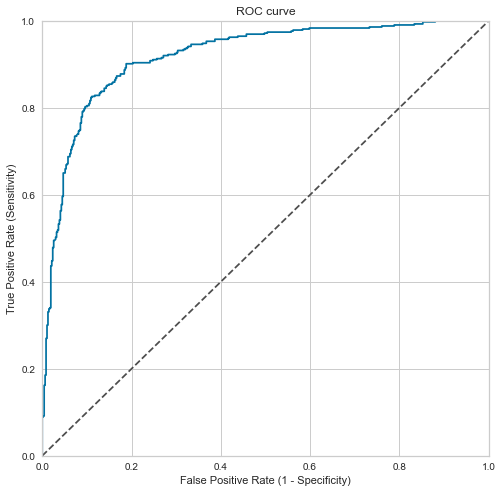

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

#split the data
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=0)

#the model
model = MLPClassifier(random_state=1, max_iter=1000)
      
#fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]

#ROC graph x and y axis
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)
print('AUC:', round((auc(fpr, tpr))*100,2), '%')

#plot the ROC graph
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Parameter Optimization <a id = 'opt'></a>

Since the MLP model was the top performing model, we wll attempt to further enhance our performance by adjusting the paramters. We can use run the model multiple times with different parameter values and see the changes in each run. 

In [76]:
# Optimize Parameters of top performing model

# Intialize gridsearch
from sklearn.model_selection import GridSearchCV

tuning_parameters = [{'hidden_layer_sizes': [100, 300],
                      'activation': ['relu'],
                      'solver': ['adam'],
                      'alpha': [1e-4, 1e-5],
                      'max_iter': [1000],
                      'random_state': [1]}]

model = GridSearchCV(MLPClassifier(), tuning_parameters, scoring='accuracy',cv = 4)

model.fit(X3, y3)

# Display gridsearch
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df_gridsearch = pd.DataFrame(model.cv_results_) 
df_gridsearch

/Users/akhilapamukuntla/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_max_iter,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,12.440263,2.475579,0.003500,0.000599,relu,0.0001,100,1000,1,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.856376,0.838926,0.841398,0.834677,0.842844,0.008174,3
1,19.466444,3.429366,0.004999,0.000944,relu,0.0001,300,1000,1,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.859060,0.853691,0.830645,0.834677,0.844519,0.012093,2
2,13.078854,1.977011,0.003227,0.000210,relu,0.00001,100,1000,1,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.856376,0.837584,0.845430,0.830645,0.842509,0.009563,4
3,17.370867,1.863828,0.008310,0.007200,relu,0.00001,300,1000,1,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.860403,0.851007,0.831989,0.834677,0.844519,0.011707,1


Using accuracy as the performance metric to evalute, we see that 'mean_test_score' does not vary too much if at all. 